# Understanding the Transformer Architecture
In this tutorial, we'll delve into the Transformer architecture, a groundbreaking model in the NLP domain. We'll use PyTorch to implement the model and understand its components.

##Prerequisites:
Basic understanding of PyTorch.
Familiarity with deep learning concepts.
##Setting up the Environment
First, let's set up our Colab environment:

In [3]:
!pip install torch torchvision tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

## 1. Self-Attention Mechanism
The self-attention mechanism allows the model to weigh the importance of different words in a sequence relative to a particular word.

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # Store attention weights
        self.attention_weights = attention

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


## 2. Transformer Block
The Transformer block consists of the self-attention mechanism and a feed-forward neural network.

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add & norm
        x = self.norm1(attention + query)
        x = self.dropout(x)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        out = self.dropout(out)
        return out


## 3. Encoder
The encoder consists of multiple Transformer blocks.

In [6]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out


## 4. Decoder
The decoder also consists of multiple Transformer blocks but also has an additional feed-forward neural network at the end to produce predicted tokens.

In [7]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, trg_mask)

        out = self.fc_out(x)
        return out


## 5. Transformer
Finally, the Transformer model combines the encoder and decoder.

In [8]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cuda",
        max_length=100,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


Let's put together a simple demonstration using the Transformer architecture for a sequence-to-sequence task. For simplicity, we'll use a toy task: reversing a sequence. This will allow us to focus on the architecture and its visualization rather than the complexities of a real-world dataset.

This code will train the Transformer model to reverse sequences and then visualize the attention weights for the first sequence in the dataset. The heatmaps will show how each head in the multi-head attention mechanism focuses on different parts of the source sequence to produce the target sequence.

**Note: **This is a toy example, and the Transformer architecture is designed for more complex tasks. However, this demonstration should give you a basic understanding of how to train the model and visualize its inner workings.

## Step-by-step Implementation:
### Data Preparation:
We'll generate sequences of integers and their reversed counterparts as source and target sequences.

### Model Training:
We'll train the Transformer model to learn this sequence reversal task.

### Visualization:
We'll visualize the attention weights to understand how the model is making its predictions.

The visualization displays the attention weights of each head in the multi-head attention mechanism. Each heatmap corresponds to one head.

**X-axis:** Represents the positions in the source sequence (e.g., each word or token in the input sentence).

**Y-axis:** Represents the positions in the target sequence (e.g., each word or token in the output sentence).

**Color:** The color in each cell of the heatmap indicates the attention weight. Darker colors (e.g., closer to purple in the "viridis" colormap) mean higher attention weights, indicating that when producing the word at the corresponding Y position, the model pays more attention to the word at the X position.

#### Interpretation:
By examining the heatmap:

You can see which parts of the input sequence (source) the model focuses on when producing each word/token of the output sequence (target).

If the model is working correctly, you might observe patterns. For instance, in a translation task, you might see attention aligning to similar-meaning words or phrases between source and target.

In our toy example of reversing a sequence, an ideal attention pattern would probably show a diagonal pattern from the top-right to the bottom-left, indicating that each output token is primarily attending to its opposite counterpart in the input.

#### Why is this Useful?
Visualizing attention weights can provide insights into how the model is making its decisions. It can help in:

**Debugging:** If the model isn't performing well, the attention patterns might show where it's going wrong.

**Interpretability:** Even if the model performs well, it's beneficial to understand how it's making decisions, especially in critical applications.

**Model Improvement:** By understanding attention patterns, one might get ideas on how to improve the model, data preprocessing, or post-processing.

In summary, the attention visualization provides a window into the inner workings of the Transformer model, helping us understand its decision-making process.

Source Sequence: tensor([1, 5, 2, 0, 0])
Target Sequence: tensor([0, 0, 2, 5, 1])


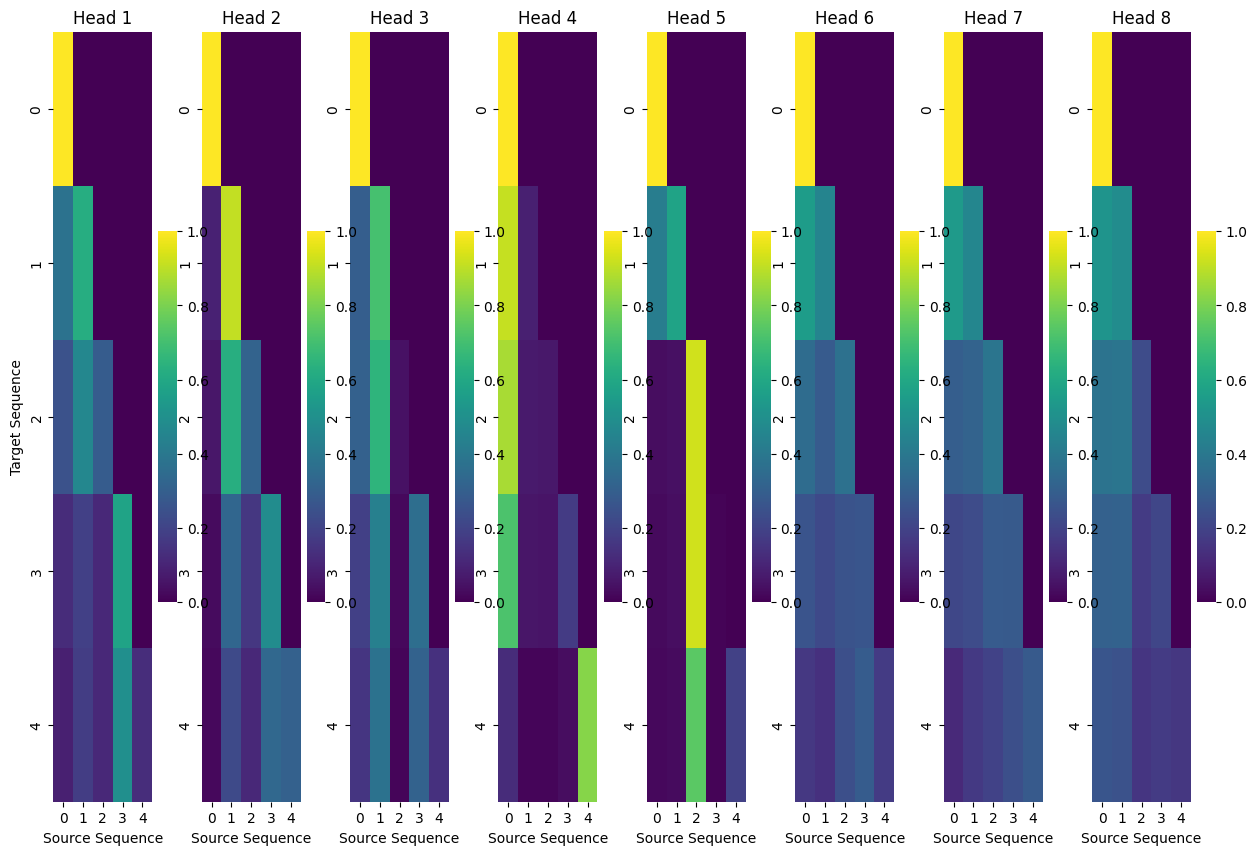

In [11]:
# Assuming all the previous classes (SelfAttention, TransformerBlock, Encoder, Decoder, Transformer) are already defined

import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64
SRC_VOCAB_SIZE = 11  # 0-9 digits and padding
TRG_VOCAB_SIZE = 11  # 0-9 digits and padding
EMBED_SIZE = 512
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.10
MAX_LENGTH = 5
FORWARD_EXPANSION = 4
SRC_PAD_IDX = 10
TRG_PAD_IDX = 10

# Data Preparation
def generate_data(num_samples=1000):
    data = []
    for _ in range(num_samples):
        seq = torch.randint(0, 10, (MAX_LENGTH,))
        rev_seq = torch.flip(seq, [0])
        data.append((seq, rev_seq))
    return data

data = generate_data()

# Model, Optimizer, and Loss
model = Transformer(
    SRC_VOCAB_SIZE,
    TRG_VOCAB_SIZE,
    SRC_PAD_IDX,
    TRG_PAD_IDX,
    EMBED_SIZE,
    NUM_ENCODER_LAYERS,
    FORWARD_EXPANSION,
    NUM_HEADS,
    DROPOUT,
    device,
    MAX_LENGTH,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# Training Loop with tqdm progress bar
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    progress_bar = tqdm(data, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}", leave=False)
    for src, trg in progress_bar:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src.unsqueeze(0), trg.unsqueeze(0))
        output = output.squeeze(0)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': total_loss / (len(data) / (BATCH_SIZE if BATCH_SIZE < len(data) else len(data)))})

# Visualization
def visualize_attention(src, trg, model):
    src, trg = src.to(device), trg.to(device)
    output = model(src.unsqueeze(0), trg.unsqueeze(0))

    # Access the attention weights from the first decoder layer
    attention = model.decoder.layers[0].attention.attention_weights.squeeze(0)

    fig, axs = plt.subplots(1, NUM_HEADS, figsize=(15, 10))
    for i, ax in enumerate(axs):
        sns.heatmap(attention[i].cpu().detach().numpy(), ax=ax, cmap="viridis")
        ax.set_title(f"Head {i + 1}")
        ax.set_xlabel("Source Sequence")
        ax.set_ylabel("Target Sequence")
    plt.show()

# Test and visualize
src, trg = data[0]
print("Source Sequence:", src)
print("Target Sequence:", trg)
visualize_attention(src, trg, model)


## Conclusion
This tutorial provided a detailed look into the Transformer architecture using PyTorch. You can now extend this base model to create state-of-the-art models like BERT and GPT!